# Czop Kałużna

# Packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.autograd.variable import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
compose = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5), (.5))
    ])

In [ ]:
def load_data(data_dir, dataset):
    if dataset == 'MNIST':
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)
        train_set = torchvision.datasets.MNIST(root=data_dir, train=True,
                                               transform=compose,download=True)
        test_set = torchvision.datasets.MNIST(root=data_dir, train=False,
                                               transform=compose,download=True)
        
    return train_set, test_set

In [4]:
def init_weights(Layer):
    name = Layer.__class__.__name__
    if name == 'Linear':
        torch.nn.init.normal_(Layer.weight, mean=0, std=0.02)
        if Layer.bias is not None:
            torch.nn.init.constant_(Layer.bias, 0)

In [ ]:
mnist_train, mnist_test = load_data(r'datasets/', 'MNIST')
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)

Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw




Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
mnist_train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

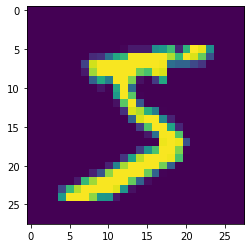

In [ ]:
plt.imshow(mnist_train.data[0])

In [2]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 784 # bo 28 * 28
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.Dropout(0.3),
            nn.ReLU()
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.Dropout(0.3),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.Dropout(0.3),
            nn.ReLU()
        )
        self.hidden3 = nn.Sequential(
            nn.Linear(256,128),
            nn.Dropout(0.3),
            nn.ReLU()
        )
        
        self.out = nn.Sequential(
            torch.nn.Linear(128, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x
    
discriminator = Discriminator()

In [3]:
class Generator(torch.nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        n_features = 100 # same as noise size
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.ReLU()
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU()
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = Generator()

In [ ]:
discriminator.apply(init_weights)
generator.apply(init_weights)

Generator(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

In [5]:
discriminator.apply(init_weights)

Discriminator(
  (hidden0): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
  )
  (hidden1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
  )
  (hidden3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# Optimizers

In [ ]:
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()

In [ ]:
num_test_samples = 10
test_noise = torch.randn(num_test_samples, 100)
test_noise.to(device)
test_noise.shape

torch.Size([10, 100])

# Training process

In [ ]:
n_epochs = 200
batch_loss_D = []
batch_loss_G = []
err_D = []
err_G = []

discriminator.train()
generator.train()

discriminator.to(device)
generator.to(device)

for epoch in range(n_epochs):
    for nr , (batch,_) in enumerate(train_loader):

        batch = batch.view(batch.shape[0], -1).float().to(device)

        N = batch.size(0) # 100 as pictures my batch size

        flatten_real_data = batch.reshape(batch.size(0),-1)
        flatten_fake_data = generator(torch.randn(N, 100).to(device)).detach() # 128 false pictures

        #Training of discriminator
        prediction_real = discriminator(flatten_real_data)
        error_real = loss(prediction_real,torch.ones(N,1).to(device))
        
        D_error_positive =torch.sum(prediction_real <= 0.5).float()/prediction_real.shape[0] * 100
        

        d_optimizer.zero_grad()
        error_real.backward()

        prediction_fake = discriminator(flatten_fake_data)
        error_fake = loss(prediction_fake,torch.zeros(N,1).to(device))
        
        D_error_negative =torch.sum(prediction_fake >= 0.5).float()/prediction_fake.shape[0] * 100
        

        error_fake.backward()
        d_optimizer.step()

        #Training of Generator
        fake_data = generator(torch.randn(N, 100).to(device))
        prediction = discriminator(fake_data)
        
        G_error = torch.sum(prediction <= 0.5).float()/prediction.shape[0] * 100

        error_gen = loss(prediction, torch.ones(N,1).to(device))

        g_optimizer.zero_grad()
        error_gen.backward()
        g_optimizer.step()
        
        batch_loss_D.append(error_real.item() + error_fake.item())
        batch_loss_G.append(error_gen.item())
        
        D_error = D_error_positive + D_error_negative
        
        err_D.append(D_error)
        err_G.append(G_error)
        
        if nr % 100 == 0:
            print(f'Batch: {nr + 100}/{600}')
            print(f'Epoch: {epoch + 1}/{n_epochs} Loss D: {error_real.item() + error_fake.item()}, Loss G : {error_fake.item()}')
            
            discriminator.eval()
            generator.eval()
            
            with torch.no_grad(): 
                sample_img = generator(test_noise.to(device))
                sample_img = sample_img.cpu()
                fig, ((ax00, ax01, ax02, ax03, ax04), (ax10, ax11, ax12, ax13, ax14)) = plt.subplots(2,5)
                ax00.imshow(sample_img[0].reshape(28,28),cmap = 'gray')
                ax01.imshow(sample_img[1].reshape(28,28),cmap = 'gray')
                ax02.imshow(sample_img[2].reshape(28,28),cmap = 'gray')
                ax03.imshow(sample_img[3].reshape(28,28),cmap = 'gray')
                ax04.imshow(sample_img[4].reshape(28,28),cmap = 'gray')
                ax10.imshow(sample_img[5].reshape(28,28),cmap = 'gray')
                ax11.imshow(sample_img[6].reshape(28,28),cmap = 'gray')
                ax12.imshow(sample_img[7].reshape(28,28),cmap = 'gray')
                ax13.imshow(sample_img[8].reshape(28,28),cmap = 'gray')
                ax14.imshow(sample_img[9].reshape(28,28),cmap = 'gray')
                plt.show()
                
            discriminator.train()
            generator.train() 
            
    if epoch % 1 == 0:
        plt.figure(figsize = (16,4))
        plt.subplot(1,2,1)
        plt.semilogy(np.arange(len(batch_loss_D)),batch_loss_D, label = 'batch D loss ')
        plt.legend()
        
        plt.subplot(1,2,1)
        plt.semilogy(np.arange(len(batch_loss_G)),batch_loss_G, label = 'batch G loss ')
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.semilogy(np.arange(len(err_D)),err_D, label = 'batch D error_rate ')
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.semilogy(np.arange(len(err_G)),err_G, label = 'batch G error_rate ')
        plt.legend()
        
        plt.show()
            

Output hidden; open in https://colab.research.google.com to view.